In [1]:
import json
import numpy as np
import imageio
import pdb
from pathlib import Path
import glob
import concurrent.futures
import cv2
from PIL import Image

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  
capture_name = 'kubric_car' 
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save mask images.
mask_dir = root_dir / 'mask'
mask_raw_dir = root_dir / 'mask-raw'
camera_gt_dir = root_dir / 'camera-gt'

camera_gt_dir.mkdir(exist_ok=True, parents=True)

with open(root_dir / 'metadata_kubric.json','r') as f:
    k_meta = json.load(f)

rgb_list = list(sorted(rgb_raw_dir.glob( '*.png')))
image_size = imageio.imread(rgb_list[0]).shape[:2]
rgb_list[:3]


[PosixPath('data/kubric_car/rgb-raw/rgba_00000.png'),
 PosixPath('data/kubric_car/rgb-raw/rgba_00001.png'),
 PosixPath('data/kubric_car/rgb-raw/rgba_00002.png')]

In [2]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.

tmp_rgb_raw_dir = rgb_raw_dir


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

if mask_raw_dir.exists():
    for mask_path in Path(mask_raw_dir).glob('*.png'):
      mask = make_divisible(imageio.imread(mask_path), max(image_scales))
      for scale in image_scales:
        save_image(
            mask_dir / f"{scale}x/{mask_path.stem.replace('segmentation','rgba')}.png",
            image_to_uint8(downsample_image(mask, scale)))


Saving data/kubric_car/rgb/1x/rgba_00196.png
Saving data/kubric_car/rgb/2x/rgba_00196.png
Saving data/kubric_car/rgb/1x/rgba_00066.png
Saving data/kubric_car/rgb/2x/rgba_00066.png
Saving data/kubric_car/rgb/1x/rgba_00012.png
Saving data/kubric_car/rgb/2x/rgba_00012.png
Saving data/kubric_car/rgb/1x/rgba_00057.png
Saving data/kubric_car/rgb/2x/rgba_00057.png
Saving data/kubric_car/rgb/1x/rgba_00044.png
Saving data/kubric_car/rgb/2x/rgba_00044.png
Saving data/kubric_car/rgb/1x/rgba_00125.png
Saving data/kubric_car/rgb/2x/rgba_00125.png
Saving data/kubric_car/rgb/1x/rgba_00081.png
Saving data/kubric_car/rgb/2x/rgba_00081.png
Saving data/kubric_car/rgb/1x/rgba_00114.png
Saving data/kubric_car/rgb/2x/rgba_00114.png
Saving data/kubric_car/rgb/1x/rgba_00009.png
Saving data/kubric_car/rgb/2x/rgba_00009.png
Saving data/kubric_car/rgb/1x/rgba_00001.png
Saving data/kubric_car/rgb/2x/rgba_00001.png
Saving data/kubric_car/rgb/1x/rgba_00134.png
Saving data/kubric_car/rgb/2x/rgba_00134.png
Saving dat

Check the generated image:

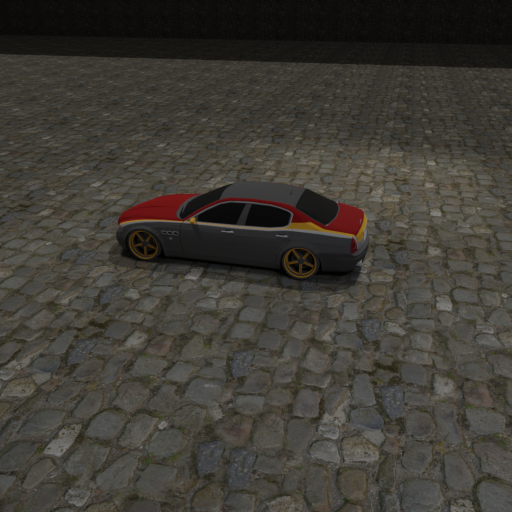

In [3]:
image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

## Write ground truth camera

In [3]:
from scipy.spatial.transform import Rotation as R

for i, rgb in enumerate(rgb_list):
    meta = {}
    quat = k_meta['camera']['quaternions'][i]
    # change quaternion format from [w,x,y,z] to [x,y,z,w]
    quat = [quat[1],quat[2],quat[3],quat[0]]
    rot = R.from_quat(quat)
    # orientation is the world to camera rotation matrix!!!
    meta['orientation'] = rot.as_matrix().T.tolist()
    meta['position'] = k_meta['camera']['positions'][i]
    meta['focal_length'] = k_meta['camera']['focal_length'] 
    meta['principal_point'] = [image_size[0]/2, image_size[1]/2] # check
    meta['skew'] = 0.
    meta['pixel_aspect_ratio'] = 1. # check
    meta['radial_distortion'] = [0., 0., 0.] # check
    meta['tangential_distortion'] = [0., 0.] # check
    meta['image_size'] = image_size

    with open(str(camera_gt_dir / rgb.stem) + '.json', 'w') as f:
        json.dump(meta, f, indent=2)

In [10]:
quat = [-0.43276604525113244, -0.2747964141011111, 0.4602476535026623, 0.7248258951777031]
quat = [quat[1],quat[2],quat[3],quat[0]]

rot = R.from_quat(quat)
rot.as_matrix()

array([[-0.47440096,  0.37441126, -0.79671823],
       [-0.88030888, -0.2017713 ,  0.42935372],
       [ 0.        ,  0.90504395,  0.42531806]])

In [6]:
rot = R.from_matrix(np.array([[-0.47440096,  0.37441126, -0.79671823],
       [-0.88030888, -0.2017713 ,  0.42935372],
       [ 0.        ,  0.90504395,  0.42531806]]))
rot.as_quat()

array([-0.27479641,  0.46024765,  0.7248259 , -0.43276604])

## Write dataset split

In [5]:
# @title Save dataset split to `dataset.json`.

VAL_RATIO = 0.1

all_ids = list(map(lambda x: x.stem,rgb_list))
val_ids = all_ids[::int(len(all_ids)*VAL_RATIO)]
train_ids = sorted(set(all_ids) - set(val_ids))

print(f'Num of train: {len(train_ids)}')
print(f'Num of val: {len(val_ids)}')

dataset_json = {
    'count': len(all_ids),
    'num_exemplars': len(train_ids),
    'ids': all_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

Num of train: 190
Num of val: 10
Saved dataset information to data/kubric_car/dataset.json


## Save metadata info

In [6]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

Saved metadata information to data/kubric_car/metadata.json


## Write scene info

In [17]:
def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])

bbox_corners = get_bbox_corners(np.array(k_meta['instances'][0]['bboxes_3d'])[0])

# scene_center = np.mean(bbox_corners, axis=0)
# scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))
scene_center = np.array([0., 0., 0.])
scene_scale = 1.0

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')

# @title Save scene information to `scene.json`.

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': 0.,
      'far': bbox_corners[1].max() * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

Scene Center: [0. 0. 0.]
Scene Scale: 1.0
Saved scene information to data/kubric_car/scene.json
